<a href="https://colab.research.google.com/github/shariqfarhan/Explore/blob/master/Assignment_8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!git clone https://github.com/shariqfarhan/EVA8-pytorch-cifar

Cloning into 'EVA8-pytorch-cifar'...
remote: Enumerating objects: 45, done.
remote: Counting objects: 100% (45/45), done.
remote: Compressing objects: 100% (40/40), done.
remote: Total 45 (delta 17), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (45/45), 15.32 KiB | 1.39 MiB/s, done.


In [3]:
!pip install torchinfo torch_lr_finder grad-cam

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 65.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.4.6-py3-none-any.whl size=38262 sha256=1dece053f5dacb5d9390a57b4ea6b6e23f3d00d38bed864ff8abe13de0bf5579
  Stored in directory: /root/.cache/pip/wheels/9b/ae/bd/221d138b169c4867b2ae5c893474d0b23bae6e4750bc95bc55
Successfully built grad-cam


In [7]:
import os
os.chdir('EVA8-pytorch-cifar')
os.listdir()

['models', 'test_model.py', 'train.py', '.git', 'utils', 'README.md']

In [8]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from torchinfo import summary
from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt



from models import Custom_ResNet
from utils.utils import get_mean_and_std, show_data_metrics, viz_data, show_images, show_model_summary
from utils.utils import AlbumentationImageDataset, plot_train_test_acc_loss, plot_misclassified_images, denormalize, plot_gradcam
from train import train
from test_model import test, mis_classified_images

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/usr/local/lib/python3.9/dist-packages/torch_lr_finder/lr_finder.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [9]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

exp = datasets.CIFAR10('./data', train = True, download = True)
exp_data = exp.data

show_data_metrics(exp_data)


100%|██████████| 170498071/170498071 [00:03<00:00, 49111978.12it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Train
- Numpy Shape : (50000, 32, 32, 3)
- min : [0. 0. 0.]
- max : [1. 1. 1.]
- mean : [0.49139968 0.48215841 0.44653091]
- std. : [0.24703223 0.24348513 0.26158784]
- var : [15.56135559 15.11767693 17.44919073]


In [10]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

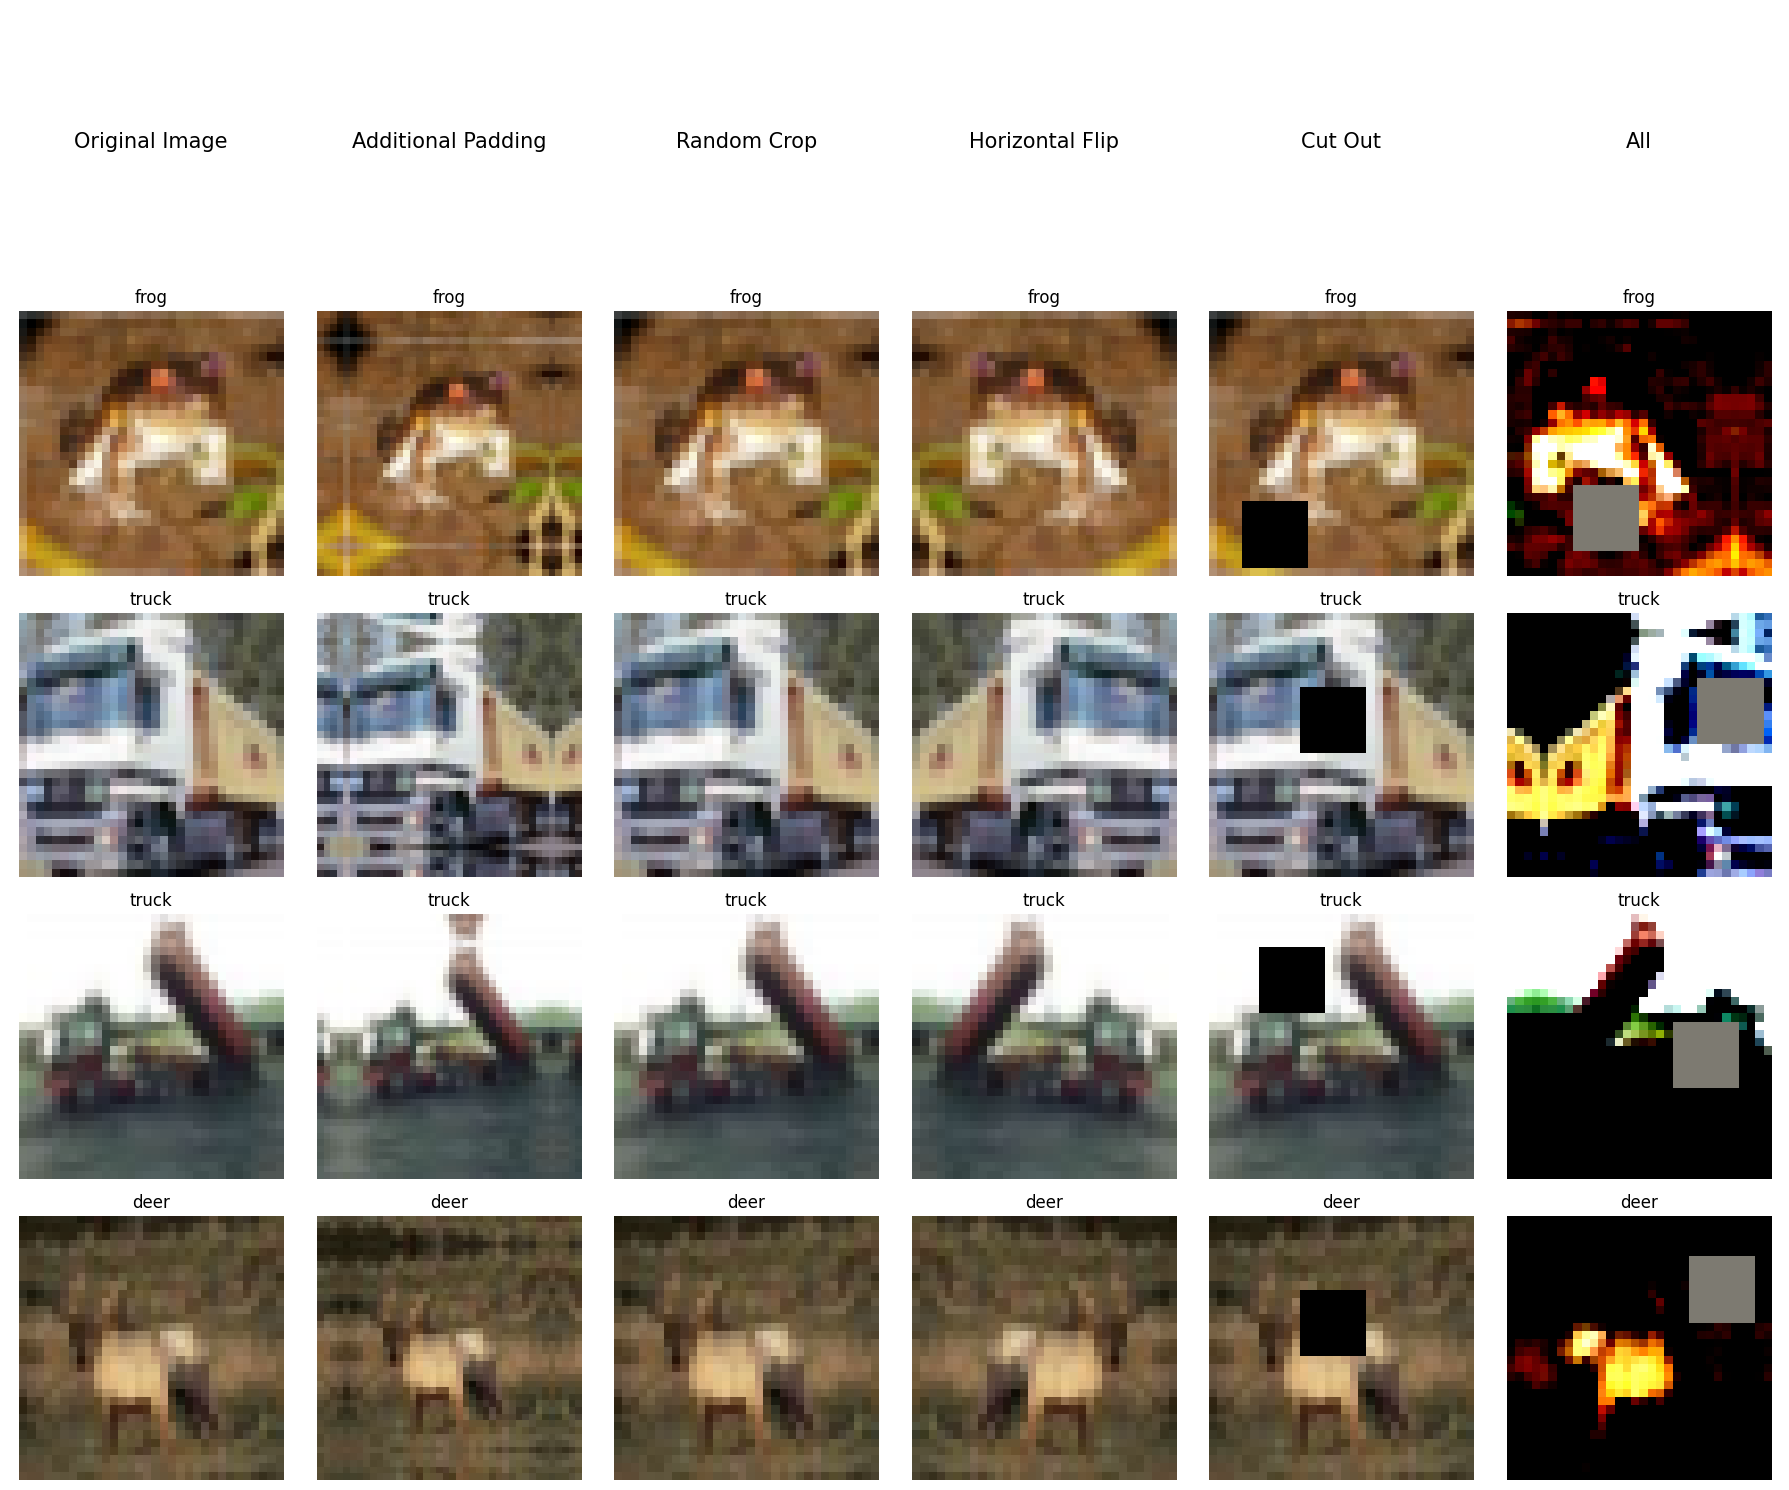

In [11]:
aug_dict = A.Sequential([
                A.Normalize((0.49139968, 0.48215841, 0.44653091), (0.24703223, 0.24348513, 0.26158784)),
                A.PadIfNeeded(min_height=40, min_width=40),
                A.RandomCrop(32, 32),
                A.HorizontalFlip(p=1),
                A.CoarseDropout(max_holes=1, max_height=8, max_width=8, min_holes=1, min_height=8,
                                min_width=8, fill_value=(0.49139968, 0.48215841, 0.44653091), mask_fill_value=None, always_apply=True)
    ])
show_images(exp,{
    'Original Image' : None,
    'Additional Padding' : A.PadIfNeeded(min_height=40, min_width=40), # Padding on both sides equal to 4 -> 32 + 2*4 = 40
    'Random Crop' : A.RandomCrop(32, 32),
    'Horizontal Flip' : A.HorizontalFlip(p=1),
    'Cut Out' : A.CoarseDropout(max_holes=1, max_height=8, max_width=8, min_holes=1, min_height=8,
                                min_width=8, fill_value=0.473363, mask_fill_value=None, always_apply=True),
    'All' : aug_dict
}, ncol = 5)

In [12]:
# session_parameters()
SEED = 1

# CUDA
cuda = torch.cuda.is_available()
print("CUDA Available:", cuda)

# For Reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)
    BATCH_SIZE = 512
else:
    BATCH_SIZE = 512

CUDA Available: True


In [13]:
trainset = torchvision.datasets.CIFAR10(root='./data', train = True, 
                                        download = True)
testset = torchvision.datasets.CIFAR10(root='./data', train = False, 
                                        download = True)

train_loader = torch.utils.data.DataLoader(AlbumentationImageDataset(trainset, train = True),
                                          batch_size = BATCH_SIZE, shuffle=True,num_workers = 2)
test_loader = torch.utils.data.DataLoader(AlbumentationImageDataset(testset, train = False),
                                          batch_size = BATCH_SIZE, shuffle=True,num_workers = 2)

Files already downloaded and verified
Files already downloaded and verified


In [14]:
from models import *
from models.Custom_ResNet import Net
model = Net()
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
show_model_summary(model)

cuda
Layer (type:depth-idx)                   Output Shape              Param #
Net                                      [16, 10]                  66,560
├─Sequential: 1-1                        [16, 64, 32, 32]          --
│    └─Conv2d: 2-1                       [16, 64, 32, 32]          1,728
│    └─BatchNorm2d: 2-2                  [16, 64, 32, 32]          128
│    └─ReLU: 2-3                         [16, 64, 32, 32]          --
│    └─Dropout: 2-4                      [16, 64, 32, 32]          --
├─Sequential: 1-2                        [16, 128, 16, 16]         --
│    └─Conv2d: 2-5                       [16, 128, 32, 32]         73,728
│    └─MaxPool2d: 2-6                    [16, 128, 16, 16]         --
│    └─BatchNorm2d: 2-7                  [16, 128, 16, 16]         256
│    └─ReLU: 2-8                         [16, 128, 16, 16]         --
│    └─Dropout: 2-9                      [16, 128, 16, 16]         --
├─ResBlock: 1-3                          [16, 128, 16, 16]         

/usr/local/lib/python3.9/dist-packages/torchinfo/torchinfo.py:477: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  action_fn=lambda data: sys.getsizeof(data.storage()),
/usr/local/lib/python3.9/dist-packages/torch/storage.py:665: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return super().__sizeof__() + self.nbytes()


In [15]:
import copy
model = Net(drop=0.1).to(device)
model_new = copy.deepcopy(model)

  0%|          | 0/100 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 5.46E-01


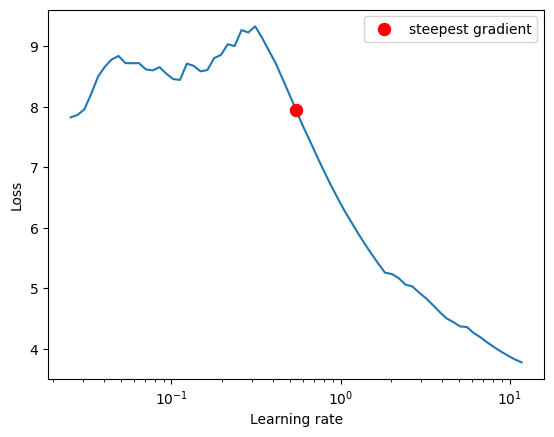

In [18]:
import torch.optim as optim
from torch_lr_finder import LRFinder


criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_new.parameters(), lr=0.01, momentum=0.9)
lr_finder = LRFinder(model_new, optimizer, criterion, device="cuda")
lr_finder.range_test(train_loader, end_lr=100, num_iter=100, step_mode="exp")
lr_finder.plot()
lr_finder.reset()

In [19]:
min_loss = min(lr_finder.history['loss'])
ler_rate = lr_finder.history['lr'][np.argmin(lr_finder.history['loss'], axis=0)]
print("Max LR is {}".format(ler_rate))

Max LR is 0.01


In [22]:
import torch.optim as optim
EPOCHS = 24

optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, 
                                                max_lr=ler_rate,
                                                steps_per_epoch=len(train_loader), 
                                                epochs=24,
                                                pct_start=5/EPOCHS,
                                                three_phase=False, 
                                                anneal_strategy='linear'
                                                ) #final_div_factor=100,
criterion = nn.CrossEntropyLoss()
train_losses, train_acc, test_losses, test_acc = list(), list(), list(), list()
for epoch in range(1, EPOCHS+1):
    print("EPOCH: {} (LR: {})".format(epoch, optimizer.param_groups[0]['lr']))
    train(model, device, train_loader, optimizer, criterion, train_losses, train_acc,scheduler, l1_penalty = True, lambda_l1 = 1e-5)
    test(model, device, test_loader, test_losses, test_acc)

EPOCH: 1 (LR: 0.0004)


Loss=2.3673577308654785 Batch_id=97 Accuracy=25.96: 100%|██████████| 98/98 [00:27<00:00,  3.50it/s]



Test set: Average loss: 1.5617, Accuracy: 4201/10000 (42.01%)

EPOCH: 2 (LR: 0.002323926380368098)


Loss=2.1892008781433105 Batch_id=97 Accuracy=39.57: 100%|██████████| 98/98 [00:28<00:00,  3.44it/s]



Test set: Average loss: 1.4020, Accuracy: 4825/10000 (48.25%)

EPOCH: 3 (LR: 0.004247852760736196)


Loss=2.2367911338806152 Batch_id=97 Accuracy=41.77: 100%|██████████| 98/98 [00:28<00:00,  3.42it/s]



Test set: Average loss: 2.0183, Accuracy: 4563/10000 (45.63%)

EPOCH: 4 (LR: 0.0061717791411042945)


Loss=2.0869522094726562 Batch_id=97 Accuracy=45.66: 100%|██████████| 98/98 [00:27<00:00,  3.51it/s]



Test set: Average loss: 1.4928, Accuracy: 5012/10000 (50.12%)

EPOCH: 5 (LR: 0.008095705521472393)


Loss=2.205122470855713 Batch_id=97 Accuracy=48.48: 100%|██████████| 98/98 [00:28<00:00,  3.45it/s]



Test set: Average loss: 1.1331, Accuracy: 6135/10000 (61.35%)

EPOCH: 6 (LR: 0.009994629452201934)


Loss=2.060209274291992 Batch_id=97 Accuracy=51.03: 100%|██████████| 98/98 [00:28<00:00,  3.44it/s]



Test set: Average loss: 1.0601, Accuracy: 6439/10000 (64.39%)

EPOCH: 7 (LR: 0.009468315767991408)


Loss=1.9966624975204468 Batch_id=97 Accuracy=56.19: 100%|██████████| 98/98 [00:28<00:00,  3.49it/s]



Test set: Average loss: 1.0376, Accuracy: 6493/10000 (64.93%)

EPOCH: 8 (LR: 0.00894200208378088)


Loss=1.7902780771255493 Batch_id=97 Accuracy=58.12: 100%|██████████| 98/98 [00:28<00:00,  3.45it/s]



Test set: Average loss: 1.0328, Accuracy: 6700/10000 (67.00%)

EPOCH: 9 (LR: 0.008415688399570355)


Loss=1.8230100870132446 Batch_id=97 Accuracy=59.86: 100%|██████████| 98/98 [00:28<00:00,  3.46it/s]



Test set: Average loss: 0.7618, Accuracy: 7344/10000 (73.44%)

EPOCH: 10 (LR: 0.007889374715359828)


Loss=1.7145123481750488 Batch_id=97 Accuracy=61.09: 100%|██████████| 98/98 [00:28<00:00,  3.48it/s]



Test set: Average loss: 0.7796, Accuracy: 7361/10000 (73.61%)

EPOCH: 11 (LR: 0.007363061031149302)


Loss=1.5972459316253662 Batch_id=97 Accuracy=63.01: 100%|██████████| 98/98 [00:28<00:00,  3.46it/s]



Test set: Average loss: 0.7783, Accuracy: 7386/10000 (73.86%)

EPOCH: 12 (LR: 0.006836747346938775)


Loss=1.5847711563110352 Batch_id=97 Accuracy=64.00: 100%|██████████| 98/98 [00:28<00:00,  3.46it/s]



Test set: Average loss: 0.7419, Accuracy: 7510/10000 (75.10%)

EPOCH: 13 (LR: 0.00631043366272825)


Loss=1.5906178951263428 Batch_id=97 Accuracy=65.37: 100%|██████████| 98/98 [00:28<00:00,  3.47it/s]



Test set: Average loss: 0.7626, Accuracy: 7453/10000 (74.53%)

EPOCH: 14 (LR: 0.0057841199785177225)


Loss=1.6446447372436523 Batch_id=97 Accuracy=65.99: 100%|██████████| 98/98 [00:28<00:00,  3.44it/s]



Test set: Average loss: 0.7080, Accuracy: 7646/10000 (76.46%)

EPOCH: 15 (LR: 0.005257806294307196)


Loss=1.6105029582977295 Batch_id=97 Accuracy=67.37: 100%|██████████| 98/98 [00:28<00:00,  3.46it/s]



Test set: Average loss: 0.6350, Accuracy: 7857/10000 (78.57%)

EPOCH: 16 (LR: 0.004731492610096671)


Loss=1.6064486503601074 Batch_id=97 Accuracy=67.80: 100%|██████████| 98/98 [00:28<00:00,  3.46it/s]



Test set: Average loss: 0.6398, Accuracy: 7829/10000 (78.29%)

EPOCH: 17 (LR: 0.004205178925886144)


Loss=1.3985605239868164 Batch_id=97 Accuracy=68.93: 100%|██████████| 98/98 [00:28<00:00,  3.42it/s]



Test set: Average loss: 0.6133, Accuracy: 7920/10000 (79.20%)

EPOCH: 18 (LR: 0.003678865241675618)


Loss=1.4219648838043213 Batch_id=97 Accuracy=69.65: 100%|██████████| 98/98 [00:28<00:00,  3.47it/s]



Test set: Average loss: 0.5675, Accuracy: 8075/10000 (80.75%)

EPOCH: 19 (LR: 0.0031525515574650905)


Loss=1.409639596939087 Batch_id=97 Accuracy=70.64: 100%|██████████| 98/98 [00:28<00:00,  3.48it/s]



Test set: Average loss: 0.5829, Accuracy: 8053/10000 (80.53%)

EPOCH: 20 (LR: 0.002626237873254565)


Loss=1.3928968906402588 Batch_id=97 Accuracy=71.71: 100%|██████████| 98/98 [00:28<00:00,  3.47it/s]



Test set: Average loss: 0.5361, Accuracy: 8213/10000 (82.13%)

EPOCH: 21 (LR: 0.0020999241890440386)


Loss=1.464630126953125 Batch_id=97 Accuracy=71.56: 100%|██████████| 98/98 [00:28<00:00,  3.45it/s]



Test set: Average loss: 0.5421, Accuracy: 8204/10000 (82.04%)

EPOCH: 22 (LR: 0.0015736105048335131)


Loss=1.3937873840332031 Batch_id=97 Accuracy=72.57: 100%|██████████| 98/98 [00:28<00:00,  3.46it/s]



Test set: Average loss: 0.5167, Accuracy: 8303/10000 (83.03%)

EPOCH: 23 (LR: 0.0010472968206229859)


Loss=1.3393802642822266 Batch_id=97 Accuracy=73.34: 100%|██████████| 98/98 [00:28<00:00,  3.47it/s]



Test set: Average loss: 0.5087, Accuracy: 8314/10000 (83.14%)

EPOCH: 24 (LR: 0.0005209831364124604)


Loss=1.3247623443603516 Batch_id=97 Accuracy=73.69: 100%|██████████| 98/98 [00:28<00:00,  3.47it/s]



Test set: Average loss: 0.4964, Accuracy: 8347/10000 (83.47%)

